In [1]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import math
import seaborn as sns
import utils
import numpy as np
import scipy.stats as stats

**1. ¿Las características del tráfico (tamaño de paquetes, tiempos entre llegadas IAT), siguen alguna distribución estadística teórica?** (univariante)
* **QQ-Plot**, skewness, kurtosis para evaluar normal
* después del primer análisis (abajo): no parecen distribuidos normales
* Gaussian Mixture Models (GMM) ?

In [2]:
date = "1112"
df_flows = utils.get_flow_df(date)
df_flows_simple = utils.get_flow_df_simple(date)
df_packets = utils.get_packet_df(date)
df_packets_simple = utils.get_packet_df_simple(date)
df_flows

,Unnamed: 0,t,ID,category,tri_category,domain,avg_read_bytes,total_read_bytes,max_read_burst_len,read_bytes_list,iat_list,avg_iat
0,0,2023-11-12 14:14:54,2023-11-12 14:14:54USAS7922,GRP,TEXT,staticxx.facebook.com,810.500000,3242,4,"[517, 875, 1392, 458]","[0.0, 0.0, 0.0]",0.000000
1,1,2023-11-12 14:16:29,2023-11-12 14:16:29USAS701,GRP,TEXT,www.facebook.com,1081.000000,3243,3,"[576, 1349, 1318]","[0.005797291000000038, 0.0001362499999999489]",0.002967
2,2,2023-11-12 14:16:30,2023-11-12 14:16:30USAS701,GRP,TEXT,twitter.com,1556.888889,14012,3,"[576, 772, 2155, 576, 2927, 576, 2927, 576, 2927]","[0.0012203130000000284, 0.0008991139999999787,...",0.012304
3,4,2023-11-12 14:16:34,2023-11-12 14:16:34USAS41378,GRP,TEXT,twitter.com,1750.500000,7002,2,"[576, 2925, 576, 2925]","[0.0024838019999999794, -0.00220614600000002, ...",0.000779
4,5,2023-11-12 14:16:54,2023-11-12 14:16:54USAS41378,MMED,MMED,www.instagram.com,1166.666667,7000,3,"[576, 1349, 1575, 576, 1349, 1575]","[0.0009055729999989381, 7.531299999996577e-05,...",0.000143
...,...,...,...,...,...,...,...,...,...,...,...,...
12121,13047,2023-11-12 08:17:20,2023-11-12 08:17:20USAS701,COMT,TEXT,telegram.org,812.000000,5684,7,"[517, 711, 1228, 1228, 412, 1228, 360]","[0.00029000000000001247, 0.0037570000000000103...",0.003450
12122,13048,2023-11-12 08:17:32,2023-11-12 08:17:32USAS701,COMT,TEXT,www.whatsapp.com,793.500000,3174,4,"[517, 863, 1380, 414]","[0.0002749999999999697, 0.0008100000000000329,...",0.001786
12123,13050,2023-11-12 08:17:53,2023-11-12 08:17:53USAS11427,GRP,TEXT,www.facebook.com,1085.000000,6510,3,"[517, 1808, 930, 517, 1808, 930]","[0.0006272920000001125, 0.001593801999999922, ...",0.052422
12124,13052,2023-11-12 08:17:55,2023-11-12 08:17:55USAS11427,GRP,TEXT,twitter.com,1751.500000,14012,2,"[517, 2986, 517, 2986, 517, 2986, 517, 2986]","[0.0006975009999999893, 0.0014217180000000162,...",0.034488


# Flows

In [256]:
flow_feature = "max_read_burst_len"

Find outliers.

In [257]:
print(len(df_flows.index))
# compute inter-quartile range
first_quartile = np.percentile(df_flows[flow_feature], 25, method='midpoint')
third_quartile = np.percentile(df_flows[flow_feature], 75, method='midpoint')
IQR = third_quartile - first_quartile
print("IQR: {}".format(IQR))

# compute upper and lower limits
lower = first_quartile - 1.5*IQR
upper = third_quartile + 1.5*IQR
 
# Find indices of outliers
upper_indices = np.where(df_flows[flow_feature]>=upper)[0]
print(upper_indices, type(upper_indices))
lower_indices = np.where(df_flows[flow_feature]<=lower)[0]
 
# Removing outliers
df_flows_IQR = df_flows.drop(index=upper_indices, inplace=False)
df_flows_IQR.drop(index=lower_indices, inplace=True)
print(len(df_flows_IQR.index))
print(len(df_flows_IQR.index)/len(df_flows.index))

# Reindex
df_flows_feature = df_flows_IQR[[flow_feature]].reset_index(drop=True)

12126
IQR: 1.0
[    7    23    37    78    85   130   149   153   166   173   187   188
   189   190   199   204   258   275   284   296   315   319   320   321
   322   323   338   347   353   376   383   404   412   437   456   469
   478   517   534   538   546   547   551   578   585   621   625   633
   648   666   668   695   715   778   799   802   823   851   877   881
   883   890   896   898   899   900   906   921   940   949   979   999
  1007  1008  1009  1010  1015  1023  1024  1025  1036  1047  1059  1090
  1130  1180  1191  1192  1193  1194  1206  1208  1216  1220  1226  1233
  1234  1235  1236  1263  1264  1265  1266  1275  1278  1282  1292  1293
  1311  1318  1332  1336  1410  1416  1422  1427  1449  1467  1512  1520
  1541  1566  1574  1585  1600  1617  1620  1621  1622  1623  1624  1634
  1638  1656  1668  1689  1697  1705  1728  1747  1757  1774  1793  1820
  1821  1850  1859  1870  1872  1885  1889  1895  1900  1904  1926  1934
  1971  2013  2031  2045  2070  2074

### Density plot of feature

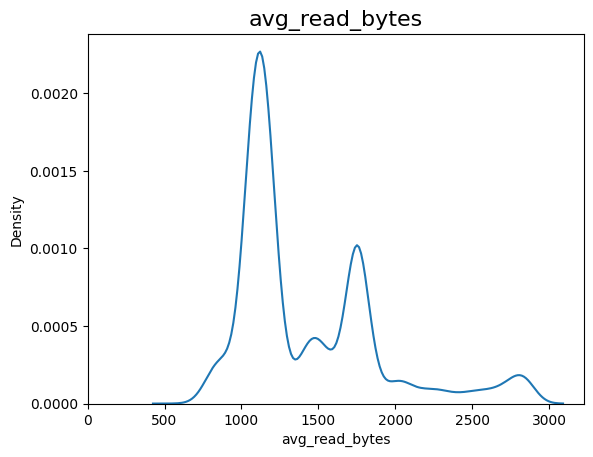

In [234]:
sns.kdeplot(df_flows_feature[flow_feature])
plt.title(flow_feature, fontsize = 16)
plt.xlim(0)
plt.show()

In [235]:
import scipy
all_data = df_flows_feature[flow_feature].values
for it in range(20):
	random_idx = np.random.randint(len(all_data), size=100)
	print(scipy.stats.kstest(all_data[random_idx], "lognorm", scipy.stats.lognorm.fit(all_data[random_idx])))

# kstest works the best for lognorm

KstestResult(statistic=0.7442609626228581, pvalue=1.3841980209018685e-57, statistic_location=925.8571428571428, statistic_sign=-1)
KstestResult(statistic=0.6903860227432157, pvalue=4.7773805957582714e-48, statistic_location=1057.3333333333333, statistic_sign=-1)
KstestResult(statistic=0.7384651237035437, pvalue=1.7550047623072315e-56, statistic_location=1057.3333333333333, statistic_sign=-1)
KstestResult(statistic=0.7581987804578545, pvalue=2.522095414012986e-60, statistic_location=1058.0, statistic_sign=-1)
KstestResult(statistic=0.7369443541143054, pvalue=3.3912669271236984e-56, statistic_location=1000.0, statistic_sign=-1)
KstestResult(statistic=0.2545894865969338, pvalue=3.349911440877328e-06, statistic_location=1167.6666666666667, statistic_sign=1)
KstestResult(statistic=0.7996553284095298, pvalue=2.587806516890999e-69, statistic_location=1000.2857142857144, statistic_sign=-1)
KstestResult(statistic=0.21514151762119232, pvalue=0.0001528732477131981, statistic_location=1167.6666666

In [236]:
data_moved = df_flows_feature[flow_feature].values - np.mean(df_flows_feature[flow_feature].values)
for it in range(5):
	random_idx = np.random.randint(len(all_data), size=100)
	print('{0:.4f}'.format(scipy.stats.kstest(data_moved[random_idx], "expon", scipy.stats.expon.fit(data_moved[random_idx])).pvalue))

0.0000
0.0000
0.0000
0.0000
0.0000


### QQ-Plot of feature

Text(0.5, 0.98, 'avg_read_bytes')

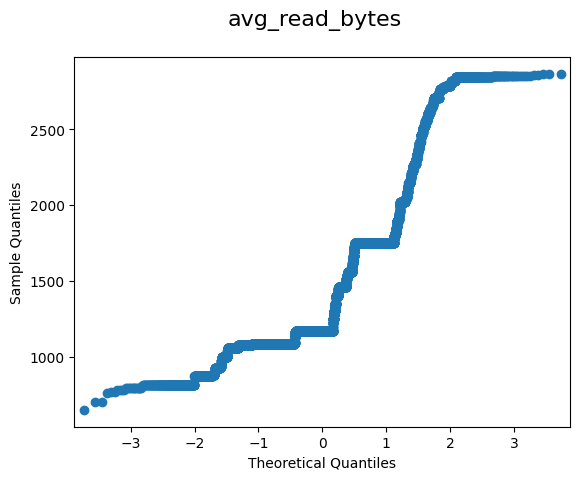

In [237]:
fig = sm.qqplot(df_flows_feature[flow_feature])
fig.suptitle(flow_feature, fontsize = 16)

### Per domain

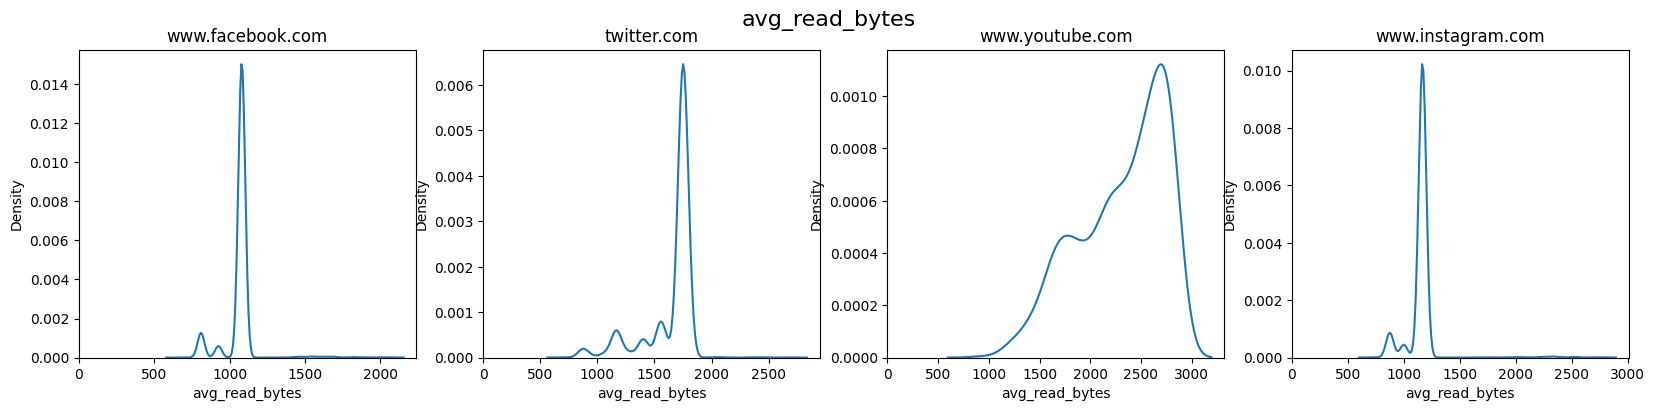

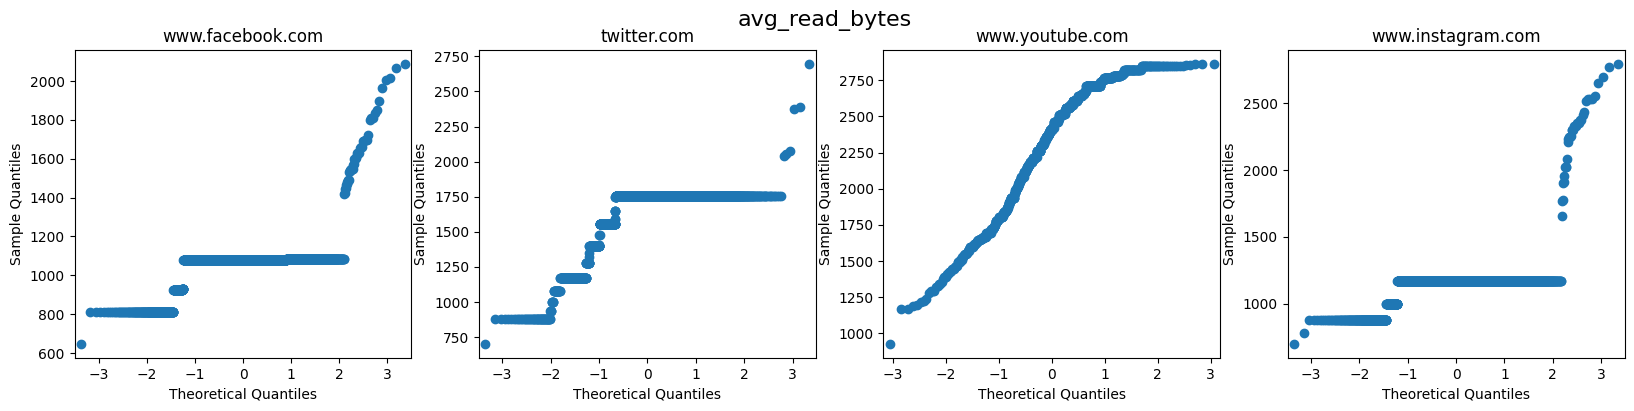

In [238]:
fig, axs = plt.subplots(1, 4, figsize=(20, 4))
fig.suptitle(flow_feature, fontsize = 16)

col = 0
for d in utils.simple_domains:
	df_domain = df_flows_IQR[df_flows_IQR["domain"] == d]
	
	sns.kdeplot(df_domain[flow_feature], ax = axs[col])
	axs[col].set_title(d)
	axs[col].set_xlim(0) 
	col += 1
	
plt.show()


fig, axs = plt.subplots(1, 4, figsize=(20, 4))
fig.suptitle(flow_feature, fontsize = 16)

col = 0
for d in utils.simple_domains:
	df_domain = df_flows_IQR[df_flows_IQR["domain"] == d]

	fig = sm.qqplot(df_domain[flow_feature], ax = axs[col])
	fig.suptitle(flow_feature, fontsize = 16)
	axs[col].set_title(d)
	col += 1

plt.show()

**No normal distribution!**

--> But Google?

In [239]:
# import scipy
# scipy.stats.kstest(df_flows_feature, 'expon')

### GMM

In [240]:
from sklearn.mixture import GaussianMixture

# for all data points 
# x = df_flows_IQR[flow_feature].values
x = data_moved
X = x[:, np.newaxis]

# gmm = GaussianMixture(n_components=3, covariance_type="full", n_init=5)
# gmm.fit(X)
# print("BIC: {}".format(gmm.bic(X)))

# for all data points 
n_components = np.arange(2, 3)
gmms = [GaussianMixture(n_components=n, covariance_type="full", n_init=5).fit(X) for n in n_components]
BICs = [gmm.bic(X.reshape(-1, 1)) for gmm in gmms]
i_min = np.argmin(BICs)
res = gmms[i_min]
res.bic(X.reshape(-1, 1))

148011.2649898917

In [241]:
# for each domain individually
for d in utils.simple_domains:
	df_domain = df_flows_IQR[df_flows_IQR["domain"] == d]
	x = df_domain[flow_feature].values
	X = x[:, np.newaxis]
	gmm = GaussianMixture(n_components=3, covariance_type="full", n_init=5)
	gmm.fit(X)
	print("BIC: {}".format(gmm.bic(X)))

BIC: 15011.5857439842
BIC: 8643.407372987822
BIC: 13118.963202317034
BIC: 3999.110756208297


0.4634847392186416 [-307.22673971] [[2114.82870414]]
0.5365152607813584 [265.4069991] [[265433.6223934]]


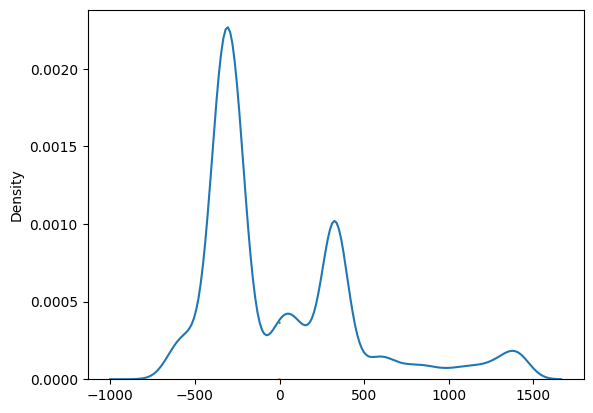

In [242]:
t = np.linspace(-0.01, 0.04, 2000) # iat
# t = np.linspace(-5, 3000, 2000)

sns.kdeplot(data_moved)

for weight, mean, cov in zip(res.weights_, res.means_, res.covariances_):
	print(weight, mean, cov)
	plt.plot(t, weight*stats.norm.pdf(t, mean, math.sqrt(cov)))
# plt.ylim(-2, 30)

In [243]:
rvs = stats.norm().rvs(size=10000)
data_now = df_flows_feature[flow_feature].values
print(data_now)
args=(np.mean(data_now), np.std(data_now))
stats.kstest(data_now, "lognorm", args=args)

[ 810.5        1081.         1556.88888889 ... 1085.         1751.5
 1167.        ]


KstestResult(statistic=0.5014440618810202, pvalue=0.0, statistic_location=648.6, statistic_sign=-1)

# Packets

In [244]:
# df_packets

In [245]:
# packet_feature = "bytes_sum"

### Find and remove outliers outside the 1.5 Inter-Quartile Range

In [246]:
# # compute inter-quartile range
# first_quartile = np.percentile(df_packets[packet_feature], 25, method='midpoint')
# third_quartile = np.percentile(df_packets[packet_feature], 75, method='midpoint')
# IQR = third_quartile - first_quartile
# print("IQR: {}".format(IQR))

# # compute upper and lower limits
# lower = first_quartile - 1.5*IQR
# upper = third_quartile + 1.5*IQR
 
# # Find indices of outliers
# upper_indices = np.where(df_packets[packet_feature]>=upper)[0]
# print(upper_indices, type(upper_indices))
# lower_indices = np.where(df_packets[packet_feature]<=lower)[0]
 
# # Removing outliers
# df_packets_IQR = df_packets.drop(index=upper_indices, inplace=False)
# df_packets_IQR.drop(index=lower_indices, inplace=True)

# # Reindex
# df_feature = df_packets_IQR[[packet_feature]].reset_index(drop=True) # 2D


In [247]:
# df_feature

### Density plot of feature 

In [248]:
# sns.kdeplot(df_feature)
# plt.title(packet_feature, fontsize = 16)
# plt.xlim(0)
# plt.show()

In [249]:
# fig = sm.qqplot(df_feature[packet_feature])
# fig.suptitle(packet_feature, fontsize = 16)

In [250]:
# import scipy.stats as ss
# ss.kurtosistest(df_feature[packet_feature])
# ss.skewtest(df_feature[packet_feature])

It looks like there are straight lines with a saddle in the QQ-plot, so let's try GMM with 2-3 components here:

In [251]:
# from sklearn.mixture import GaussianMixture
# import scipy.stats as stats
# import math

# x = df_feature[packet_feature].values
# X = x[:, np.newaxis]

# # for all data points 
# n_components = np.arange(2, 4)
# gmms = [GaussianMixture(n_components=n, covariance_type="full", n_init=5).fit(X) for n in n_components]
# BICs = [gmm.bic(X.reshape(-1, 1)) for gmm in gmms]
# i_min = np.argmin(BICs)
# res = gmms[i_min]

In [252]:
# print(i_min)
# BICs[i_min]

In [253]:
# t = np.linspace(-0.08, 200000, 2000)

# sns.kdeplot(df_feature)

# for weight, mean, cov in zip(res.weights_, res.means_, res.covariances_):
# 	print(weight, mean, cov)
# 	plt.plot(t, weight*stats.norm.pdf(t, mean, math.sqrt(cov)))
# # plt.ylim(-2, 30)

### 